# Pipeline for predicting house prices
This is a simple example of how to: take a modest dataset, distill the feature set through exploratory data analysis, and then scale down features and train a variety of regression models via a pipeline. In the end, I select the random forest regression model, which typically yields very good results, and apply a grid search to tune model parameters, before predicting prices.

## Imports

In [171]:
import sklearn.datasets as datasets

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline

from sklearn.externals import joblib

from sklearn.metrics import mean_squared_error

# We want to make sure all numbers display in a consistent manner
pd.options.display.float_format = '{:.5f}'.format

## Loading in data

In this case we are using the standard sklearn dataset called 'Boston House Prices', which contains features about houses (e.g. location, age, number of rooms, basement area), where the median values of the properties are the target values.

### Boston House Prices dataset

#### Notes

Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's


In [194]:
# Load dataset
data = datasets.load_boston()
# Extract feature names, predictors and targets from sklearn dictionary
names = data.feature_names
predictors = data.data
targets = data.target
# Concatenate predictors and targets for easier processing later on. Let's also name the columns.
df = pd.concat([pd.DataFrame(predictors, columns=names), pd.DataFrame(targets, columns=['MEDV'])], axis=1)

## Inspecting data
We have everything in one table with all columns labelled, as intended.

In [195]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.00000,2.31000,0.00000,0.53800,6.57500,65.20000,4.09000,1.00000,296.00000,15.30000,396.90000,4.98000,24.00000
1,0.02731,0.00000,7.07000,0.00000,0.46900,6.42100,78.90000,4.96710,2.00000,242.00000,17.80000,396.90000,9.14000,21.60000
2,0.02729,0.00000,7.07000,0.00000,0.46900,7.18500,61.10000,4.96710,2.00000,242.00000,17.80000,392.83000,4.03000,34.70000
3,0.03237,0.00000,2.18000,0.00000,0.45800,6.99800,45.80000,6.06220,3.00000,222.00000,18.70000,394.63000,2.94000,33.40000
4,0.06905,0.00000,2.18000,0.00000,0.45800,7.14700,54.20000,6.06220,3.00000,222.00000,18.70000,396.90000,5.33000,36.20000


Lets confirm what type of values we have (should all be floating values).

In [196]:
df.dtypes.value_counts()

float64    14
dtype: int64

Lets summarize each attribute. From a glance we could expect some of the data to be quite skewed.

In [197]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000
mean,3.59376,11.36364,11.13678,0.06917,0.55470,6.28463,68.57490,3.79504,9.54941,408.23715,18.45553,356.67403,12.65306,22.53281
std,8.59678,23.32245,6.86035,0.25399,0.11588,0.70262,28.14886,2.10571,8.70726,168.53712,2.16495,91.29486,7.14106,9.19710
min,0.00632,0.00000,0.46000,0.00000,0.38500,3.56100,2.90000,1.12960,1.00000,187.00000,12.60000,0.32000,1.73000,5.00000
25%,0.08204,0.00000,5.19000,0.00000,0.44900,5.88550,45.02500,2.10018,4.00000,279.00000,17.40000,375.37750,6.95000,17.02500
50%,0.25651,0.00000,9.69000,0.00000,0.53800,6.20850,77.50000,3.20745,5.00000,330.00000,19.05000,391.44000,11.36000,21.20000
75%,3.64742,12.50000,18.10000,0.00000,0.62400,6.62350,94.07500,5.18843,24.00000,666.00000,20.20000,396.22500,16.95500,25.00000
max,88.97620,100.00000,27.74000,1.00000,0.87100,8.78000,100.00000,12.12650,24.00000,711.00000,22.00000,396.90000,37.97000,50.00000


We can also plot histograms for each column to get a clear idea of the shape of the data. It might be a good idea to redistribute some of the data. I will skip over it for now.

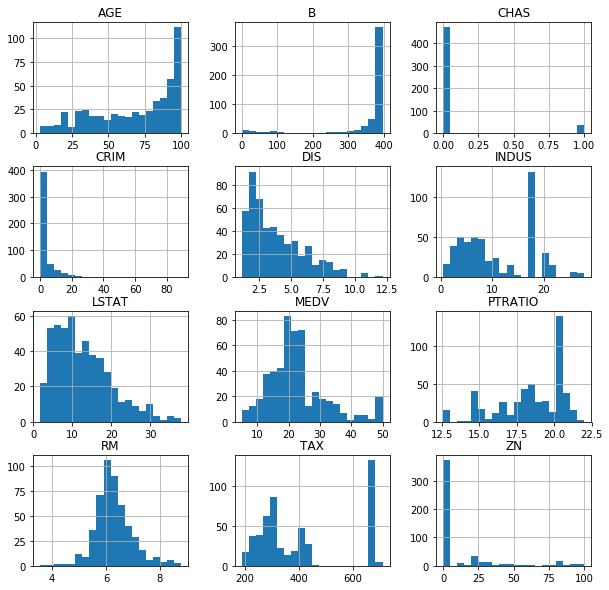

In [208]:
df.hist(figsize=(10, 10), bins=20)
plt.show()

We need to make sure we don't have any Nan values in our dataset, otherwise the ML algorithms will fail.

In [198]:
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Now lets see if we can find strong correlations between columns.

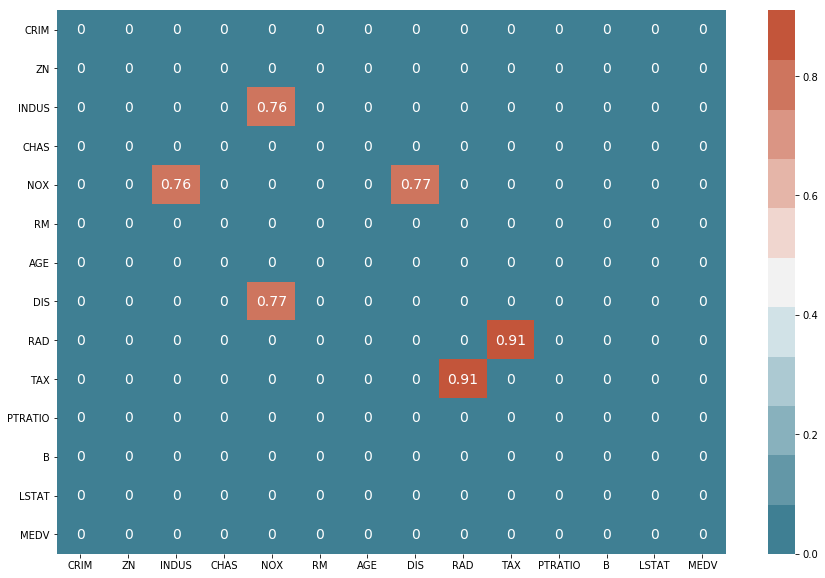

In [199]:
df_corr = df.corr().abs()
filter = (df_corr == 1) | (df_corr < 0.75)
df_corr[filter] = 0
df_corr

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, annot=True, annot_kws={'size': 14},
            cmap=sns.diverging_palette(220, 20, n=11))

## Dimensionality reduction
From the previous plot, we were able to ascertain that the 'NOX' and the 'RAD' columns are strongly correlated with other columns. Therefore, lets go ahead a drop them from our dataframe.

In [200]:
cols_corr_manual = ['NOX', 'RAD']
df = df.drop(columns=cols_corr_manual)
df.head()

,CRIM,ZN,INDUS,CHAS,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.00000,2.31000,0.00000,6.57500,65.20000,4.09000,296.00000,15.30000,396.90000,4.98000,24.00000
1,0.02731,0.00000,7.07000,0.00000,6.42100,78.90000,4.96710,242.00000,17.80000,396.90000,9.14000,21.60000
2,0.02729,0.00000,7.07000,0.00000,7.18500,61.10000,4.96710,242.00000,17.80000,392.83000,4.03000,34.70000
3,0.03237,0.00000,2.18000,0.00000,6.99800,45.80000,6.06220,222.00000,18.70000,394.63000,2.94000,33.40000
4,0.06905,0.00000,2.18000,0.00000,7.14700,54.20000,6.06220,222.00000,18.70000,396.90000,5.33000,36.20000


## Setting up train and test datasets
Now we are ready to peel of the last column and assign to the target (y) variable and the rest of the data can be assigned to the predictor (X) variable. After that, we use the sklearn train_test_split function to create train and test datasets for both X and y.

In [201]:
# Train-set predictors/targets
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

## Initialising models, setting up a pipeline, training and predicting
For this part, I would like a list of regression models, then I will create a pipeline that scales the data, reduces feature dimensionality (via PCA) and trains the model, all in one go. We can loop through each model, inserting it into the pipeline, and then finally we can see how the models compare to one another.

In [210]:
# Lets append tuples to the list that contain both the name of the model and the model itself
# This is what the pipeline expects
models = []
models.append( ('LR', LinearRegression()) )
models.append( ('Lasso', Lasso()) )
models.append( ('ElasticNet', ElasticNet()) )
models.append( ('KNN', KNeighborsRegressor()) )
models.append( ('CART', DecisionTreeRegressor()) )
models.append( ('SVR', SVR()) )

In [204]:
# Now we can loop through the models and run the pipeline each time
for name, model in models:
    pipelined_model = Pipeline([('minmax', MinMaxScaler()), 
                     ('pca', PCA(n_components = 3)), 
                     (name, model)])
    
    # Train model
    pipelined_model.fit(X_train, y_train)
    
    # Make predictions on the test-set
    y_hat = pipelined_model.predict(X_test)
    
    # Calculate error
    RMSE = np.sqrt(mean_squared_error(y_test, y_hat))
    print('Model: ', name, ' | RMSE: ', RMSE)
    print('----------------')
    
    # I also like to save the models each time as a matter of habit
    joblib.dump(pipelined_model, '{}_model.pkl'.format(name))

Model:  LR  | RMSE:  7.15970109322
----------------
Model:  Lasso  | RMSE:  7.57962692126
----------------
Model:  ElasticNet  | RMSE:  8.1579157098
----------------
Model:  KNN  | RMSE:  6.36588579546
----------------
Model:  CART  | RMSE:  9.45087919969
----------------
Model:  SVR  | RMSE:  7.60464954267
----------------


We will now run the pipeline just once with yet another model - the RandomForest regressor - and incorporate a gridsearch to tune the model parameters.

In [ ]:
# The pipeline as before, but this time the model type is static
pipelined_model = Pipeline([('minmax', MinMaxScaler()), 
                 ('pca', PCA(n_components = 3)), 
                 ('RF', RandomForestRegressor())])

grid = {
        'RF__n_estimators': [100, 200, 300, 400, 500],
        'RF__max_depth': [10, 20, 30, 40, 50],
        'RF__min_samples_leaf': [10, 15, 20, 25, 30]
        }

# Run cross-validation & discover best combination of params, with 10 folds of cross-validation
grid_search_cv = GridSearchCV(pipelined_model, 
                              grid, 
                              cv=KFold(n_splits=10, random_state=7), 
                              scoring='neg_mean_squared_error',
                              n_jobs = -1)

results = grid_search_cv.fit(X_train, y_train)

print(results.best_score_)
print(results.best_params_)

Now we can create a new instance of the pipeline and pass the 'best_params_' of the gridsearch directly into the regressor.

In [205]:
pipelined_model = Pipeline([('minmax', MinMaxScaler()), 
                 ('pca', PCA(n_components = 3)), 
                 ('RF', RandomForestRegressor(n_estimators=results.best_params_['RF__n_estimators'],
                                              max_depth=results.best_params_['RF__max_depth'],
                                              min_samples_leaf=results.best_params_['RF__min_samples_leaf']))])

pipelined_model.fit(X_train, y_train)

joblib.dump(pipelined_model, 'RF_model.pkl')

['RF_model.pkl']

Once more, we make predictions using the test set.

In [206]:
# Lets make predictions on the test-set
y_hat = pipelined_model.predict(X_test)

# Calc error
RMSE = np.sqrt(mean_squared_error(y_test, y_hat))
print('Model: Random forest', ' | ', 'RMSE: ', RMSE)

Model: Random forest  |  RMSE:  6.31066783749


Turns out that our RMSE score wins out by a very tight margin. Let's bare in mind that we off by about $6000 US here, because the target values are counted in the 100